# Analysis and Visualization of newspaper articles in the Chronicling America site at the Library of Congress
### J Ammerman / 20151214

In [1]:
import os
import pandas as pd
import numpy as np
from urllib.request import urlopen
import json
import matplotlib as plt
%matplotlib inline
import random
import seaborn as sns
sns.set(color_codes=True)
sns.set_context('talk',font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
from textblob import TextBlob,Word

## define function to remove unwanted characters from the strings returned in the response
def clean_str(s):
    chrs = ["[","]","'"]
    if type(s) != str:
        return('')

    for c in chrs:
        s=s.replace(c,"")
    return(s)

## change to the working directory
os.chdir('/Volumes/jwa_drive1/git/news')

In [2]:
## Build the url that will be sent to the web site
##
states = {'Arizona':7,'California':7,'Connecticut':1,'District of Columbia':9,'Florida':2,'Hawaii':11,'Idaho':5,
          'Illinois':4,'Indiana':4,'Iowa':4,'Kansas':10,'Kentucky':3,'Louisiana':3,'Michigan':6,'Minnesota':6,
          'Mississippi':3,'Missouri':4,'Montana':5,'Nebraska':10,'Nevada':5,'New Mexico':7,'New York':1,
          'North Carolina':2,'North Dakota':6,'Ohio':4,'Oklahoma':10,'Oregon':8,'Pennsylvania':9,'South Carolina':2,
          'South Dakota':6,'Tennessee':3,'Texas':7,'Utah':5,'Vermont':1,'Virginia':9,'Washington':8,'West Virginia':9}
regions = {1:'Northeast',2:'Southeast',3:'South',4:'Midwest', 5:'Mountain', 6:'UpperPlains', 7:'Southwest',8:'Northwest',9:'MidAtlantic',10:'Plains',11:'Other'}

base_url = 'http://chroniclingamerica.loc.gov/search/pages/results/?searchType=basic'
variables ={}
page = 1
variables['date1'] = '1836'
variables['date2'] = '1922'
variables['proxtext'] = 'suffrage+suffragette'
#variables['proxtext'] = 'immigrant+immigration'
variables['x'] = '0'
variables['y'] = '0'
variables['dateFilterType'] = 'year'
variables['rows'] = '50'
variables['state'] = ''
variables['format'] = 'json'
variables['page'] = str(page)
url = base_url
for k,v in variables.items():
    url += '&' + k + '=' + v
## Uncomment the line below if you want to see the search url
#print(url)

## The response will come back as a 'bytes' string. We need to decode it and remove new line
## characters. 
response = urlopen(url).read().decode().replace('\n','')
## Having cleaned up the response string, we still need to convert it to a JSON object
## We do that with the 'json.loads()' function
response_json = json.loads(response)
## one of the fields returned from the web site is the totalItems that match the response.
## we use that value and the value of the number of rows returned to calculate the number of
## pages we need to request
totalItems = response_json['totalItems']
pages = (totalItems/int(variables['rows']))+1
## we create an empty pandas dataframe to hold the results and then query the web site,
## incrementing the page number with each call.
df = pd.DataFrame()
while page < pages:
    variables['page'] = str(page)
    url = base_url
    page += 1
    for k,v in variables.items():
        url += '&' + k + '=' + v
    response = urlopen(url).read().decode().replace('\n','')
    response_json = json.loads(response)
    ## the item level information from each article is in the field 'items' 
    ## we create a list of the items and then iterate through that list, adding
    ## the information for each article to the dataframe
    items_list = response_json['items']
    for item_json in items_list:
        df = df.append(item_json, ignore_index=True)

## we need to clean and restructure the data, so we create a new dataframe and a dict that
## will hold the data
df1 = pd.DataFrame()
r = {}
for index,row in df.iterrows():
    ## for each row in the the dataframe ('df') we clean unwanted characters and structure
    ## the data into a more easily analyzed form
    r['title'] = clean_str(row.title[0])
    r['title_normal'] = clean_str(row.title_normal[0])
    r['city'] = clean_str(row.city[0])
    r['state'] = clean_str(row.state[0])
    r['region'] = states[row.state[0]]
    r['region_word'] = regions[states[row.state[0]]]
    r['county'] = clean_str(row.county[0])
    r['place_of_publication'] = clean_str(row.place_of_publication)
    r['year'] = row.date[:4]
    r['month'] = row.date[4:6]
    r['day'] = row.date[6:8]
    r['text'] = row.ocr_eng
    ## we use textblob to do sentiment analysis on the content of the article
    pos_neg = TextBlob(row.ocr_eng)
    r['polarity'] = pos_neg.sentiment.polarity
    r['subjectivity'] = pos_neg.sentiment.subjectivity
    r['page'] = row.page
    r['publisher'] = clean_str(row.publisher)
    r['place'] = clean_str(row.place[0])
    r['country'] = clean_str(row.country[0])
    r['url'] = clean_str(row.url[0])
    ## we add each processed row to the new dataframe (df1)
    df1 = df1.append(r,ignore_index=True)


## Here we simply display the frequency of articles published by year

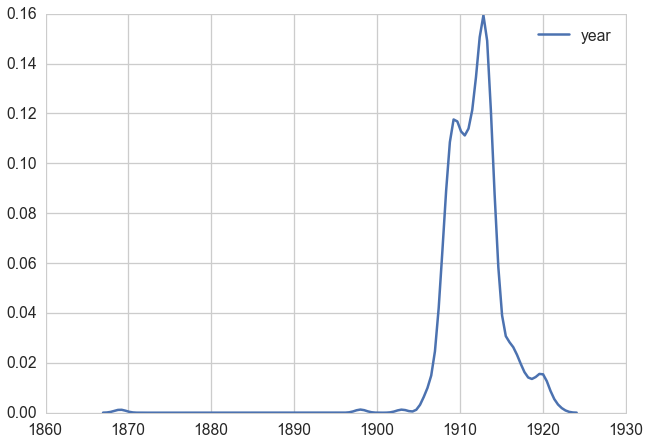

In [4]:
sns.kdeplot(df1.year)

##To more easily visualize the changing sentiment of the articles, we group the articles by year and calcuate the sum of the polarity and subjectivity fields

In [5]:
## we create a new 'grouped' dataframe by grouping by year
grouped = df1.groupby('year').mean()
grouped['year'] = grouped.index
grouped['year'] = grouped['year'].astype(float)

##The kernel density plot below shows the change in the polarity of sentiment over time

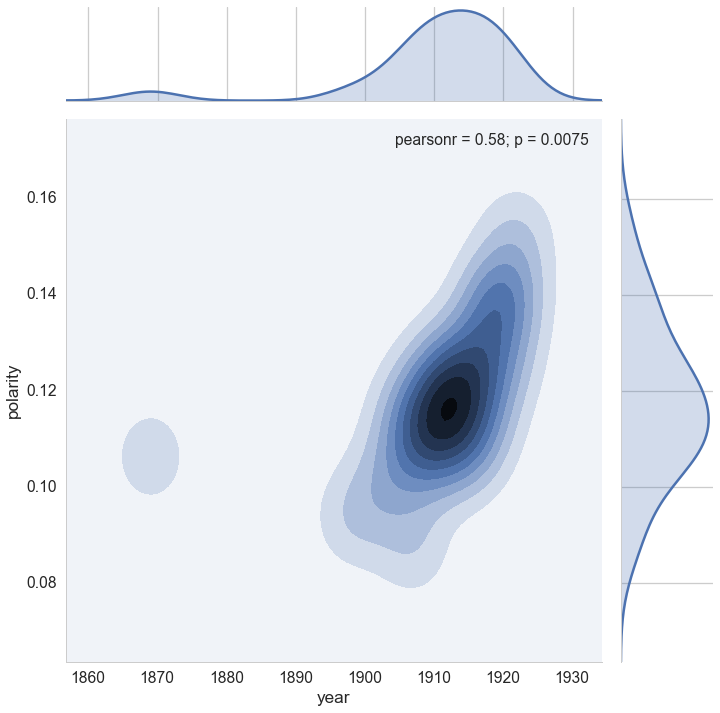

In [7]:

sns.jointplot(x='year', y='polarity', data=grouped, kind="kde",size=10)

In [9]:
region = df1.groupby(['region']).mean()
region['region'] = region.index


In [10]:
# Define the aggregation calculations
aggregations = {
    'city' : {
        'city' : 'count'
    },
    'year' : {
        'year' : 'count'
        
    },

    'region_word' : {
        'Count per region' : 'count'
        
    },
    'polarity' : {
        'polarity_mean' : 'mean'
        
    },
    'state' : {
        'state': 'count'
        
    }
}

In [11]:
by_region = df1.groupby(['year','region_word']).agg(aggregations)

In [12]:
by_region

year      polarity city      region_word state
                 year polarity_mean city Count per region state
year region_word                                               
1869 Midwest        1      0.106372    1                1     1
1898 MidAtlantic    1      0.093453    1                1     1
1903 Northeast      1      0.101543    1                1     1
1906 MidAtlantic    1      0.225932    1                1     1
     Midwest        1      0.049652    1                1     1
     Plains         1      0.116699    1                1     1
     Southwest      1      0.101644    1                1     1
     UpperPlains    1      0.083962    1                1     1
1907 MidAtlantic    3      0.093708    3                3     3
     Northeast      1      0.091889    1                1     1
     Northwest      1      0.080386    1                1     1
     UpperPlains    1      0.070933    1                1     1
1908 MidAtlantic    8      0.105937    8                8     8
     Midwest        3      0.081161    3                3     3
     Mountain       2      0.146742    2                2     2
     Northeast     15      0.109286   15               15    15
     Plains         1      0.025755    1                1     1
     South          1      0.162222    1                1     1
     Southwest      2      0.105688    2                2     2
     UpperPlains    1      0.097091    1                1     1
1909 MidAtlantic   12      0.106105   12               12    12
     Midwest        2      0.117350    2                2     2
     Mountain       5      0.117058    5                5     5
     Northeast     13      0.093342   13               13    13
     Northwest      8      0.105100    8                8     8
     Plains         3      0.103907    3                3     3
     South          6      0.080541    6                6     6
     Southeast      1      0.126381    1                1     1
     Southwest     11      0.141590   11               11    11
     UpperPlains    3      0.115885    3                3     3
...               ...           ...  ...              ...   ...
1915 UpperPlains    1      0.098733    1                1     1
1916 MidAtlantic    3      0.151933    3                3     3
     Midwest        2      0.126926    2                2     2
     Northeast      3      0.127407    3                3     3
     Northwest      1      0.159179    1                1     1
     Plains         1      0.150656    1                1     1
     Southwest      4      0.086194    4                4     4
1917 MidAtlantic    4      0.111469    4                4     4
     Mountain       2      0.094881    2                2     2
     Northeast      2      0.138061    2                2     2
     UpperPlains    3      0.116791    3                3     3
1918 MidAtlantic    3      0.116400    3                3     3
     Northeast      1      0.181684    1                1     1
     Plains         1      0.123230    1                1     1
     South          1      0.161317    1                1     1
1919 MidAtlantic    1      0.165994    1                1     1
     Midwest        2      0.165623    2                2     2
     Northwest      1      0.124802    1                1     1
     South          1      0.109214    1                1     1
     Southeast      1      0.105530    1                1     1
1920 MidAtlantic    2      0.130717    2                2     2
     Mountain       1      0.144310    1                1     1
     Northeast      1      0.069264    1                1     1
     Southeast      2      0.123600    2                2     2
     Southwest      2      0.150822    2                2     2
     UpperPlains    1      0.113230    1                1     1
1921 Mountain       1      0.121212    1                1     1
     South          1      0.144776    1                1     1
     Southeast      1      0.153914    1         